# Pengenalan Motif Batik dengan Algoritma Convolutional Neural Network

Menginstall Library yang diperlukan:
- Torch
- Numpy
- Opencv

In [10]:
! pip install torch
! pip install numpy
! pip install opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 31.7 MB/s eta 0:00:0000:0100:01


Mengimport Library yang digunakan:
- os : Untuk mengakses direktori dan berkas yang berinteraksi langsung dengan Sistem Operasi
- torch : Untuk mengembangkan, melatih, dan menguji model Deep Learning
- torch.nn : Untuk membangun arsitektur model
- torch.optim : Untuk mengoptimalkan model
- DataLoader dari torch.utils.data : Untuk membantu bekerja dengan data yang sesuai dengan model Deep Learning
- transforms dari torchvision : Untuk melakukan transformasi pada gambar, seperti resize, rotasi, dan normalisasi
- ImageFolder dari torchvision.datasets : dataset yang dapat digunakan untuk memuat data gambar dari direktori berstruktur
- train_test_split : Untuk membagi dataset menjadi data pelatihan dan pengujian
- LabelEncoder : Untuk mengkodekan label kelas
- classification_report : Untuk menghasilkan laporan klasifikasi.
- numpy: Untuk berinteraksi dengan array dan struktur data numerik.

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import numpy as np

#### Mengunduh sebuah file ZIP dari IBM Cloud Object Storage (COS) dan mengekstraknya
Library yang diperlukan: 
- ibm_boto3 : Untuk berinteraksi dengan layanan cloud, khususnya dengan layanan cloud IBM Cloud. ibm_boto3 digunakan untuk berkomunikasi dengan COS.

- botocore.client : Untuk mengonfigurasi klien (client) yang akan berkomunikasi dengan layanan cloud.

- zipfile : Untuk mengelola file ZIP yaitu untuk mengekstrak isi dari file ZIP yang di unduh dari COS.

- io : Untuk mengelola input/output data. io digunakan untuk membaca dan menulis data ke dalam buffer, yang selanjutnya digunakan untuk mengekstrak file ZIP.

In [4]:
from botocore.client import Config
import ibm_boto3
import zipfile
import io

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='ZqaqxRkR7l18k4KkONQvPGk85Dq59qaxcPoLj7MHFFxG',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us-south.cloud-object-storage.appdomain.cloud')

bucket = 'yosefssandbox-donotdelete-pr-cagqakt1o1thhr'
object_key = 'dataset-batik-main.zip'

# Mengambil objek StreamingBody
streaming_body = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']

# Membaca konten StreamingBody ke dalam buffer
buffer = io.BytesIO(streaming_body.read())

# Membuka file ZIP
with zipfile.ZipFile(buffer, 'r') as zip_ref:
    # Ekstrak semua isi ZIP ke dalam direktori saat ini
    zip_ref.extractall()

#### Melihat Isi Direktori Data
Mengumpulkan informasi tentang file-file yang ada dalam direktori (dan subdirektori) dan menyimpan informasi tersebut dalam bentuk DataFrame menggunakan Pandas. Informasi yang dikumpulkan mencakup nama file, path lengkap file, dan ukuran file. 

In [5]:
import pandas as pd

# Tentukan path ke direktori data
data_dir = 'dataset-batik-main'

# Loop melalui file dalam direktori
file_info = [(file, os.path.join(root, file), os.path.getsize(os.path.join(root, file)))
             for root, dirs, files in os.walk(data_dir) for file in files]

# Buat dataframe dari informasi file
df = pd.DataFrame(file_info, columns=['Nama File', 'Path File', 'Ukuran File'])

# Tampilkan dataframe
print(df)

    Nama File                                    Path File  Ukuran File
0      50.jpg  dataset-batik-main/batik-cendrawasih/50.jpg        41545
1      19.jpg  dataset-batik-main/batik-cendrawasih/19.jpg       109092
2      10.jpg  dataset-batik-main/batik-cendrawasih/10.jpg        30078
3      38.jpg  dataset-batik-main/batik-cendrawasih/38.jpg       102756
4      26.jpg  dataset-batik-main/batik-cendrawasih/26.jpg        47590
..        ...                                          ...          ...
968    34.jpg  dataset-batik-main/batik-megamendung/34.jpg       154303
969    14.jpg  dataset-batik-main/batik-megamendung/14.jpg       554065
970     9.jpg   dataset-batik-main/batik-megamendung/9.jpg       608739
971     8.jpg   dataset-batik-main/batik-megamendung/8.jpg        73295
972     5.jpg   dataset-batik-main/batik-megamendung/5.jpg        44437

[973 rows x 3 columns]


### 1. Inisialisasi Path dan Parameter-Model
- Variabel data_dir menunjukkan path ke direktori data_batik di mana data gambar motif batik disimpan. 
- Variabel output_model yang akan digunakan untuk menyimpan model yang telah dilatih.
- Variabel learning_rate, epochs, dan batch_size yang merupakan parameter-parameter pelatihan model, seperti laju pembelajaran (learning rate), jumlah iterasi pelatihan (epochs), dan ukuran batch yang digunakan saat melatih model.


### 2. Membaca dan Memproses Data Gambar
- Menggunakan transforms.Compose untuk melakukan perubahan ukuran gambar, rotasi acak, pemutaran cermin horizontal acak, perubahan kecerahan, kontras, saturasi, dan hue acak, serta normalisasi gambar.


### 3. Inisialisasi Dataset menggunakan ImageFolder
- ImageFolder dari PyTorch digunakan untuk membaca data gambar dari direktori. Setiap subdirektori dalam data_dir akan dianggap sebagai kelas yang berbeda dalam dataset, dan gambar-gambar dalam setiap subdirektori akan dianggap sebagai contoh-contoh dari kelas tersebut.


### 4. Inisialisasi Label Encoder
- LabelEncoder digunakan untuk mengubah label kelas menjadi angka. 


### 5. Split Dataset Menjadi Data Pelatihan dan Pengujian
- train_test_split dari scikit-learn digunakan untuk memisahkan dataset menjadi data pelatihan dan pengujian. Data pengujian adalah subset yang akan digunakan untuk menguji seberapa baik model bekerja.


### 6. Ubah y_train dan y_test Menjadi Array NumPy
- Label kelas yang telah diubah oleh LabelEncoder diubah menjadi array NumPy agar dapat digunakan saat pelatihan model.


### 7. Inisialisasi DataLoader untuk Data Pelatihan dan Pengujian
- DataLoader digunakan untuk mengelola data dalam batch saat pelatihan dan pengujian model. Ini membantu meningkatkan efisiensi pelatihan dengan menghindari pengolahan gambar satu per satu.
- shuffle=True digunakan pada train_loader agar data dalam setiap batch diacak untuk variasi yang lebih baik saat pelatihan.
- shuffle=False pada test_loader karena tidak perlu mengacak data pengujian.

In [6]:
# Inisialisasi path ke direktori data gambar
data_dir = 'dataset-batik-main'
output_model = 'batik_model.pth'

# Inisialisasi parameter-model
learning_rate = 0.0001  
epochs = 30  
batch_size = 64  

# Membaca dan memproses data gambar
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Inisialisasi dataset menggunakan ImageFolder
dataset = ImageFolder(root=data_dir, transform=transform)

# Inisialisasi label encoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(dataset.targets)

# Split dataset menjadi data pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(dataset.imgs, labels, test_size=0.2, random_state=42)

# Ubah y_train dan y_test menjadi array NumPy
y_train = np.array(y_train).tolist()
y_test = np.array(y_test).tolist()

# Inisialisasi DataLoader untuk data pelatihan dan pengujian
train_dataset = ImageFolder(root=data_dir, transform=transform)
test_dataset = ImageFolder(root=data_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Convolutional Neural Network
Convolutional Neural Network (CNN), atau jaringan saraf tiruan konvolusi, adalah jenis arsitektur jaringan saraf tiruan yang khusus dirancang untuk tugas pengolahan citra dan pengenalan pola dalam data visual. CNN memiliki kemampuan unik untuk mengekstrak fitur-fitur penting dari gambar dan digunakan secara luas dalam berbagai aplikasi penglihatan komputer, termasuk klasifikasi gambar, deteksi objek, segmentasi gambar, dan banyak lagi

##### 1. Definisi Kelas BatikCNN
- Kelas ini dibangun dengan model CNN menggunakan PyTorch.
- num_classes : Parameter yang menentukan jumlah kelas yang akan diidentifikasi oleh model, dan digunakan untuk menentukan jumlah unit output di layer terakhir.

##### 2. Inisialisasi Layer-layer CNN 
Model CNN ini terdiri dari beberapa layer:
- self.conv1: Layer konvolusi pertama dengan 3 saluran input (RGB), 32 saluran keluaran, dan kernel berukuran 3x3 dengan padding 1. Konvolusi berperan penting dalam proses ekstraksi fitur dari gambar input dan memainkan peran kunci dalam kemampuan jaringan untuk mengenali pola dalam data visual.
- self.relu1: Layer aktivasi ReLU setelah layer konvolusi pertama. ReLu digunakan untuk meningkatkan kemampuan jaringan dalam memodelkan data yang kompleks
- self.pool1: Layer max-pooling dengan kernel berukuran 2x2 dan langkah (stride) 2 setelah layer aktivasi pertama. max-pooling membantu mereduksi resolusi dan dimensi spatials sehingga jaringan dapat belajar fitur-fitur yang lebih abstrak dan kompleks dari layer konvolusi sebelumnya.
- Langkah-langkah yang sama diulangi untuk layer konvolusi kedua (self.conv2), aktivasi kedua (self.relu2), dan max-pooling kedua (self.pool2).
- Kemudian, ada layer konvolusi ketiga (self.conv3), aktivasi ketiga (self.relu3), dan max-pooling ketiga (self.pool3).

##### 3. Inisialisasi Layer-layer Fully Connected (FC)
Setelah layer konvolusi dan max-pooling, terdapat tiga layer FC:
- self.fc1: Layer FC pertama dengan 128 * 28 * 28 input (dengan 128 sebagai jumlah saluran keluaran dari layer konvolusi ketiga), dan 512 neuron di layer ini. Layer FC digunakan untuk menghubungkan setiap unit dalam layer ini dengan setiap unit dalam layer sebelumnya, menciptakan koneksi penuh (fully connected). Ini berarti setiap unit di layer FC menerima input dari semua unit di layer sebelumnya.
- self.relu4: Layer aktivasi ReLU setelah layer FC pertama.
- self.dropout: Layer dropout dengan tingkat dropout sebesar 50%. Ini digunakan untuk mencegah overfitting dengan secara acak mematikan setengah dari unit selama pelatihan.
- self.fc2: Layer FC kedua dengan jumlah neuron yang sesuai dengan jumlah kelas yang akan diidentifikasi.


##### 4. Batch Normalization
- Ada tiga layer batch normalization (self.bn1, self.bn2, self.bn3) setelah layer konvolusi pertama, kedua, dan ketiga. Batch normalization digunakan untuk mempercepat pelatihan dan mengurangi overfitting dengan normalisasi data di dalam setiap batch.

##### 5. Metode forward
- Metode forward mendefinisikan aliran data melalui model.
- Data masukan pertama kali melewati layer konvolusi, aktivasi, dan max-pooling dalam urutan yang sesuai.
- Kemudian, data diproses melalui layer FC, aktivasi ReLU, dropout, dan layer FC terakhir.
- Hasil output adalah hasil dari klasifikasi dengan jumlah neuron yang sesuai dengan jumlah kelas yang akan diidentifikasi.

##### 6. Inisialisasi Model
- Pada akhir kode, model BatikCNN diinisialisasi dengan jumlah kelas yang sesuai dengan jumlah kelas dalam dataset yang telah dienkoding sebelumnya.

In [7]:
# Membangun model CNN dengan perubahan pada tingkat dropout
class BatikCNN(nn.Module):
    def __init__(self, num_classes):
        super(BatikCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Tingkat dropout 50%
        self.fc2 = nn.Linear(512, num_classes)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = BatikCNN(num_classes=len(label_encoder.classes_))

#### Kompilasi Model
Mengkompilasi model CNN yang sudah dibangun dengan menentukan fungsi kerugian (loss function) dan optimizer yang akan digunakan untuk pelatihan. Fungsi kerugian yang digunakan di sini adalah nn.CrossEntropyLoss(). Kemudian optimizer yang digunakan adalah optimizer Adam (optim.Adam) untuk mengoptimalkan bobot dan bias dalam model. Learning rate (tingkat pembelajaran) untuk optimizer ini telah ditentukan di dalam variabel learning_rate yang telah ditentukan sebelumnya.

#### Pelatihan Model
1. Melakukan pelatihan model dalam loop for dengan jumlah epoch yang telah ditentukan sebelumnya.
2. Pada setiap epoch, model diatur dalam mode pelatihan (model.train()).
3. Data pelatihan dimuat dalam batch menggunakan train_loader, dan proses pelatihan dilakukan:
- Optimizer diatur ulang (optimizer.zero_grad()) untuk menghapus gradien dari iterasi sebelumnya.
- Gambar dimasukkan ke model (outputs = model(images)) untuk menghasilkan prediksi.
- Menghitung nilai fungsi kerugian (loss) antara prediksi dan label yang sebenarnya.
- Melakukan backpropagation (loss.backward()) untuk menghitung gradien dan memperbarui bobot model menggunakan optimizer (optimizer.step()).


#### Simpan Model
Setelah pelatihan selesai, model disimpan ke dalam file dengan nama yang telah ditentukan dalam variabel output_model.

#### Evaluasi Model
- Setelah model dilatih, hal yang dilakukan selanjutnya adalah mengevaluasi kinerjanya pada data pengujian.
- Model diatur dalam mode evaluasi (model.eval()), yang mematikan dropout dan mengubah perilaku beberapa lapisan lainnya yang mungkin berbeda antara mode pelatihan dan evaluasi.
- Kemudian melakukan iterasi melalui data pengujian dalam test_loader dan mengumpulkan prediksi dari model.
- Prediksi dari model dibandingkan dengan label sebenarnya, dan hasilnya disimpan dalam predictions dan true_labels.

#### Laporan Klasifikasi
- Mencetak laporan klasifikasi yang menyajikan metrik evaluasi seperti akurasi, presisi, recall, dan F1-score untuk setiap kelas yang ada dalam dataset.
- Label kelas telah dikonversi menjadi daftar string dari kelas-kelas yang sesuai dengan bantuan dari label_encoder.classes_.
- Hasil laporan klasifikasi memberikan informasi tentang seberapa baik algoritma CNN dalam mengklasifikasikan berbagai kelas dalam dataset pengujian.

In [8]:
# Kompilasi model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Melatih model
for epoch in range(epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Simpan model
torch.save(model.state_dict(), output_model)

# Evaluasi model
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Mengubah label_encoder.classes_ menjadi daftar string
target_names = [str(label) for label in label_encoder.classes_]

# Cetak laporan klasifikasi
print(classification_report(true_labels, predictions, target_names=target_names))

              precision    recall  f1-score   support

           0       0.98      0.86      0.91        49
           1       1.00      0.96      0.98        50
           2       1.00      1.00      1.00        47
           3       0.96      1.00      0.98        49
           4       0.91      0.88      0.89        48
           5       0.96      0.92      0.94        48
           6       0.94      0.96      0.95        50
           7       1.00      0.96      0.98        50
           8       0.84      0.96      0.90        45
           9       0.94      0.88      0.91        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        46
          12       0.96      0.90      0.93        50
          13       0.91      1.00      0.95        50
          14       0.94      0.92      0.93        48
          15       0.94      0.98      0.96        47
          16       0.96      0.90      0.93        50
          17       0.83    

### APLIKASI PENGENALAN MOTIF BATIK 
Mengimport Library yang diperlukan:
1. from PIL import Image, ImageTk : Untuk mengelola dan menampilkan gambar.
2. import cv2 : Untuk pemrosesan gambar.
3. import random : Untuk menghasilkan angka acak.
4. from IPython.display import display, Image as IPImage : Untuk menampilkan gambar dan konten lainnya dalam notebook.

In [11]:
import random
import cv2
from PIL import Image
from IPython.display import display, Image as IPImage

##### Membaca Dataset dan Inisialisasi Variabel:
- class_names: Ini digunakan untuk mengidentifikasi kategori batik.
- threshold: Ini adalah ambang probabilitas dalam bentuk desimal yang digunakan untuk memutuskan apakah gambar dianggap sebagai gambar batik atau bukan.

##### Transformasi Gambar:
- Transformasi ini mencakup pengubahan ukuran gambar menjadi 224x224 piksel, mengonversi gambar menjadi tensor, dan normalisasi gambar.

##### Fungsi verify_batik(image_path):
- Fungsi ini digunakan untuk memeriksa apakah sebuah gambar mungkin adalah gambar batik berdasarkan ciri-ciri tertentu, seperti pola atau tekstur yang umumnya terdapat pada batik.
- Menggunakan OpenCV (Open Source Computer Vision Library) untuk melakukan operasi seperti mengubah gambar menjadi skala abu-abu, mendeteksi tepi (edges), dan menemukan garis-garis dalam gambar.
- Jika ditemukan garis-garis yang cukup dalam gambar, maka gambar tersebut mungkin dianggap sebagai gambar batik.

##### Fungsi predict_batik_with_class_name_and_accuracy(image_path, model, class_names, threshold):
- Fungsi ini digunakan untuk memprediksi apakah sebuah gambar batik dan mengembalikan nama kelas prediksi, akurasi prediksi, dan status prediksi (benar atau salah) berdasarkan ambang probabilitas.
- Membaca gambar, melakukan transformasi yang diperlukan, dan menggunakan model CNN (Convolutional Neural Network) untuk memprediksi kelas gambar.
- Hasil prediksi dan akurasi diperiksa dengan ambang probabilitas yang telah ditentukan.


##### Membaca Model CNN yang Sudah Dilatih:
- Model CNN yang telah dilatih sebelumnya dimuat dengan jumlah kelas yang sesuai. Model ini akan digunakan untuk memprediksi gambar.

##### Memilih Gambar Secara Acak:
Program akan memilih gambar secara acak dari dataset yang sudah diberikan.

##### Verifikasi Gambar:
Memeriksa apakah gambar yang dipilih ada dan kemudian menggunakan fungsi verify_batik untuk memeriksa apakah gambar tersebut mungkin adalah gambar batik.
- Jika Gambar adalah Batik:
Jika hasil verifikasi menunjukkan bahwa gambar mungkin adalah gambar batik, program membuka gambar, mengubah ukurannya, dan menampilkannya. Selanjutnya, program menggunakan fungsi predict_batik_with_class_name_and_accuracy untuk melakukan prediksi terhadap gambar tersebut, mengembalikan nama kelas yang diprediksi, akurasi prediksi, dan status prediksi.
- Jika Gambar Bukan Batik:
Jika hasil verifikasi menunjukkan bahwa gambar bukan gambar batik, program mencetak pesan yang menyatakan bahwa gambar tersebut bukan gambar batik.


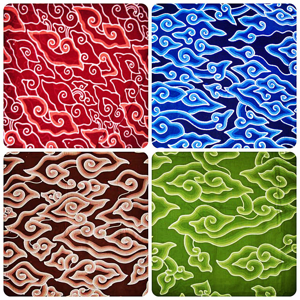

Prediksi: batik-megamendung (97.67% Akurasi, Benar)


In [21]:
# Inisialisasi path ke model yang sudah dilatih
model_path = 'batik_model.pth'
data_dir = 'dataset-batik-main' 

# Membaca dataset untuk mendapatkan daftar nama kelas (nama folder)
class_names = sorted(os.listdir(data_dir))

# Ambang probabilitas (dalam bentuk desimal, misalnya 0.5)
threshold = 0.5

# Membaca dan memproses data gambar
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Mengubah gambar menjadi tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #Normalisasi
])
# Fungsi untuk memverifikasi apakah gambar mungkin adalah gambar batik
def verify_batik(image_path):
    # Baca gambar dengan OpenCV
    image = cv2.imread(image_path)

    # Lakukan pengujian berdasarkan ciri-ciri gambar batik
    # Menguji pola atau tekstur yang umumnya ada dalam gambar batik
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_image, 50, 150)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)

    if lines is not None:
        return True  # Kemungkinan gambar batik
    else:
        return False  # Bukan gambar batik

# Fungsi untuk memprediksi gambar batik dengan nama kelas dan akurasi
def predict_batik_with_class_name_and_accuracy(image_path, model, class_names, threshold):
    # Baca gambar dan aplikasikan transformasi
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0) 

    # Gunakan model untuk memprediksi kelas
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = predicted.item()

    # Dapatkan nama kelas yang sesuai dengan indeks prediksi
    predicted_class_name = class_names[predicted_class]

    # Hitung akurasi gambar berdasarkan top-1 probability
    softmax = torch.nn.Softmax(dim=1)
    probabilities = softmax(outputs)[0].cpu().numpy()
    top1_probability = probabilities[predicted_class]
    accuracy_percentage = round(top1_probability * 100, 2)

    # Tentukan prediksi apakah benar atau salah berdasarkan ambang probabilitas
    prediction_accuracy = "Benar" if top1_probability >= threshold else "Salah"

    return predicted_class_name, accuracy_percentage, prediction_accuracy

# Membaca model yang sudah dilatih
model = BatikCNN(num_classes=len(class_names)) 
model.load_state_dict(torch.load(model_path))
model.eval()

# Mendapatkan daftar semua gambar dalam dataset
all_images = []
for root_folder, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')): 
            all_images.append(os.path.join(root_folder, file))

# Memilih gambar secara acak
selected_image_path = random.choice(all_images)

# Verifikasi apakah gambar ada
if not os.path.exists(selected_image_path):
    print(f'File gambar tidak ditemukan: {selected_image_path}')
    # Keluar dari program atau melakukan tindakan lain sesuai kebutuhan
    exit()  # Ini akan mengakhiri program jika gambar tidak ditemukan

# Verifikasi apakah gambar mungkin adalah gambar batik
is_batik = verify_batik(selected_image_path)

if is_batik:
    # Membaca dan mengubah ukuran gambar
    image = Image.open(selected_image_path)
    image = image.resize((300, 300))

    # Ubah mode warna gambar menjadi RGB
    image = image.convert("RGB")

    # Menampilkan gambar di kolom output
    display(image)

    # Melakukan prediksi
    predicted_class_name, accuracy_percentage, prediction_accuracy = predict_batik_with_class_name_and_accuracy(
        selected_image_path, model, class_names, threshold)
    print(f'Prediksi: {predicted_class_name} ({accuracy_percentage}% Akurasi, {prediction_accuracy})')
else:
    print('Gambar bukan batik')
